# Weekdays vs Weekends

## Libraries import

In [65]:
library(tidyverse)
library(dplyr)
library(ggplot2)

In [66]:
Sys.setlocale("LC_TIME","C")
options(stringsAsFactors=FALSE)
theme_set(theme_bw()) # just my preference for plots

[1] "C"

## Data import and structuring

In [67]:
read_met <- function(filename) {
  data <- read_table(filename, skip=15, 
    col_names= c("year", "month", "day", "hour", "minute", "WIRI", "WIGE"),
    col_types = paste(collapse = "", c(rep("i", 5), rep("n", 2))))
  data %>%
    mutate(datetime = make_datetime(year, month, day, hour, minute, tz = "CEST"),
           year     = year(datetime),
           month    = month(datetime),
           day      = day(datetime),
           hour     = hour(datetime),
           minute   = minute(datetime),
           WIRI     = ifelse(WIRI <= -9999, NA, WIRI),
           WIGE     = ifelse(WIGE <= -9999, NA, WIGE))
}

In [68]:
month2season <- function(month) {
  ## month is an integer (1-12)
  ## a factor with levels {"Winter : DJF", "Spring : MAM", "Summer : JJA", "Autumn : SON"} is returned
  seasons <- c("Winter", "Spring", "Summer", "Autumn")
  index <- findInterval(month %% 12, seq(0, 12, 3))
  factor(seasons[index], seasons)
}

wday2type <- function(wday) {
  ## wday is an integer with 1 = Monday, 2 = Tuesday, ... and 7 = Sunday
  c("Weekday", "Weekend")[(unclass(wday) - 1) %/% 5 + 1]
}

In [69]:
read_tseries <- function(filename, timecolumn = "Date/time", timeformat = "%d.%m.%Y %H:%M", tz = "Etc/GMT-1", delta = 3600) {
  ## read the table, strip units in column names, rename time column
  ##   and change data type of time column from a string of characters to
  ##   a numeric type so that we can perform operations on it

  data <- read_delim(filename, skip = 5, delim = ";", locale = locale(encoding = "Latin1"), show_col_types = FALSE)

  out <- data %>%
    rename_with(.fn = function(x) sub("[ ].*$", "", x)) %>% # strip units for simplification
    rename(datetime = !!timecolumn) %>%
    mutate(datetime = parse_date_time(datetime, !!timeformat, !!tz) - !!delta) %>%
    mutate(year = year(datetime),
           month = month(datetime),
           day = day(datetime),
           hour = hour(datetime),
           dayofwk = wday(datetime, label = TRUE, week_start = 1),
           daytype = wday2type(dayofwk),
           season = month2season(month),
           .after = datetime)
}

In [70]:
datapath <- file.path("Data")

all_data_df <- full_join(
  bind_cols(site="DAV", read_tseries(file.path(datapath, "DAV.csv"))),
  bind_cols(site="BAS", read_tseries(file.path(datapath, "BAS.csv")))
)

#all_data_df

Joining with `by = join_by(site, datetime, year, month, day, hour, dayofwk, daytype, season, O3, NO2, PM10, NOX, TEMP,
PREC, RAD)`


In [71]:
all_data_lf <- all_data_df %>%
  pivot_longer(-c(site, datetime, season, year, month, day, hour, dayofwk, daytype),  # id columns
               names_to = "variable",
               values_to = "value")

## Pollutants' results 

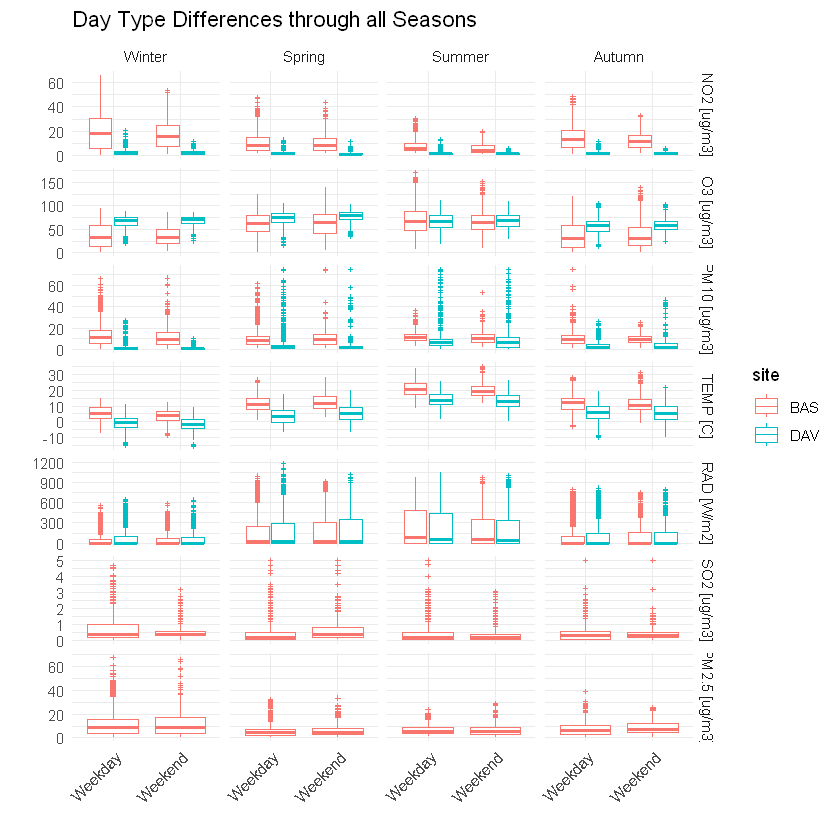

In [99]:
# both sites on the same graph
daytype <- all_data_lf %>%
  filter(!is.na(value) & !is.na(season) & !variable %in% c("CPC", "EC", "NOX", "PREC")) %>%
  mutate(value = case_when(
    variable == "PM10" ~ pmin(value, 75),  # cap PM10 values at 100
    variable == "SO2" ~ pmin(value, 5),     # cap SO2 values at 5
    TRUE ~ value
  ))

  
daytype_plot<-ggplot(daytype) +
  facet_grid(variable ~ season, scales = "free_y", labeller = labeller(
    variable = c(
      "NO2" =  "NO2 [ug/m3]",
      "O3" = "O3 [ug/m3]",
      "PM10" = "PM10 [ug/m3]",
      "PM2.5" = "PM2.5 [ug/m3]",
      "PREC" = "PREC [mm]",
      "RAD" = "RAD [W/m2]",
      "SO2" = "SO2 [ug/m3]",
      "TEMP" = "TEMP [C]"
    )
  )) + 
  geom_boxplot(
    aes(x = daytype, y = value, color = site),
    outlier.size = 0.5, 
    outlier.shape = 3
  ) +
    labs(
    x = "",  # Label for the x-axis
    y = "",  # Label for the y-axis
    title = "Day Type Differences through all Seasons"  # Title for the plot
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

daytype_plot

ggsave("outputs/daytype.jpeg", plot = daytype_plot, width = 9, height = 9, dpi = 300)

## Precipitation analysis

`summarise()` has grouped output by 'daytype', 'variable', 'season'. You can override using the `.groups` argument.


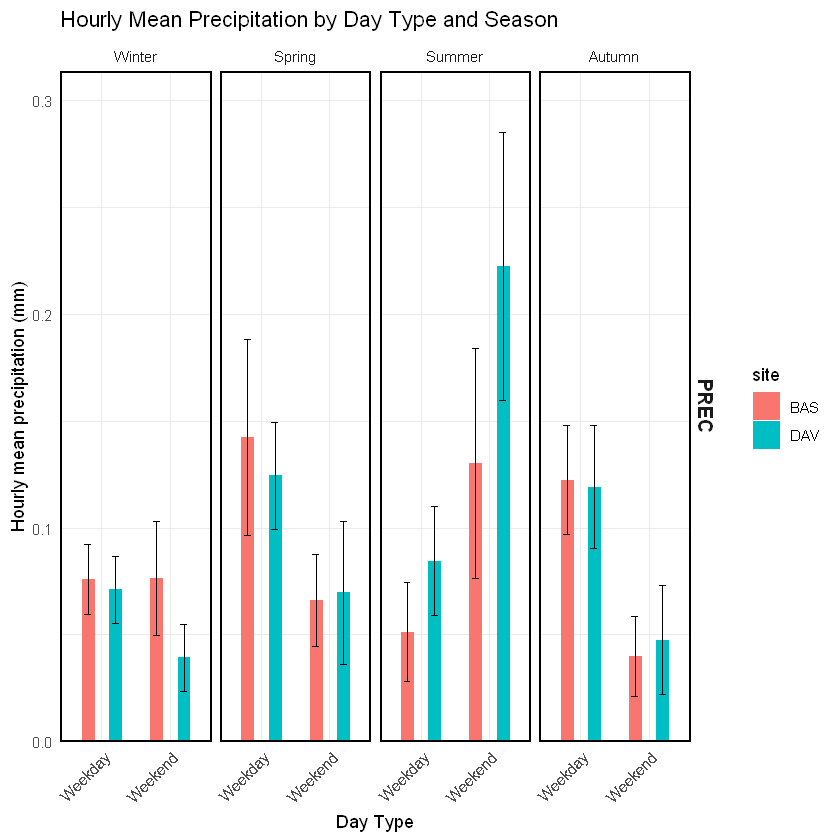

In [73]:
Precipitation_data <- all_data_lf %>%
  filter(!is.na(value) & variable == "PREC" & !is.na(season)) %>%
  group_by(daytype, variable, season, site) %>%
  summarise(
    mean_value = mean(value, na.rm = TRUE),
    sd_value = sd(value, na.rm = TRUE),
    n = sum(!is.na(value)),  # Sample size (excluding NA)
    se_value = sd_value / sqrt(n),  # Standard error
    ci_value = qt(0.975, df = n - 1) * se_value  # 95% Confidence Interval
  )

precipitations_plot_1 <-ggplot(Precipitation_data,
    aes(
    x = daytype, 
    y = mean_value, 
    color = site,
    fill=site
  )
) +
  facet_grid(variable ~ season, scales = "free_y") +
  # Adjust the dodge width for bars and error bars to avoid superimposition
  geom_bar(
    stat = "identity", 
    show.legend = TRUE, 
    position = position_dodge(width = 0.8),  # Separate bars for each site
    width = 0.35  # Adjust bar width to avoid overlap
  ) +  # Mean values as bars
  geom_errorbar(
    aes(ymin = mean_value - ci_value, ymax = mean_value + ci_value), 
    width = 0.2, 
    position = position_dodge(width = 0.8),  # Align error bars with the bars for each site
    color = "black"
  ) +  # 95% CI error bars
  labs(
    x = "Day Type",  # Label for the x-axis
    y = "Log10 of Precipitation (mm)",  # Label for the y-axis
    title = "Hourly Mean Precipitation by Day Type and Season"  # Title for the plot
  ) +
  scale_y_continuous("Hourly mean precipitation (mm)", expand = expansion(mult = c(0, 0.1))) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    strip.text.y = element_text(size = 12, face = "bold"),  # Make facet labels bolder
    panel.border = element_rect(color = "black", fill = NA, size = 1)  # Add box around each facet
  )

precipitations_plot_1

ggsave("outputs/precipitations_DayType_sites.jpeg", plot = precipitations_plot_1, width = 6, height = 5, dpi = 300)


Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 15456 rows containing non-finite values (`stat_boxplot()`)."
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 15456 rows containing non-finite values (`stat_boxplot()`)."


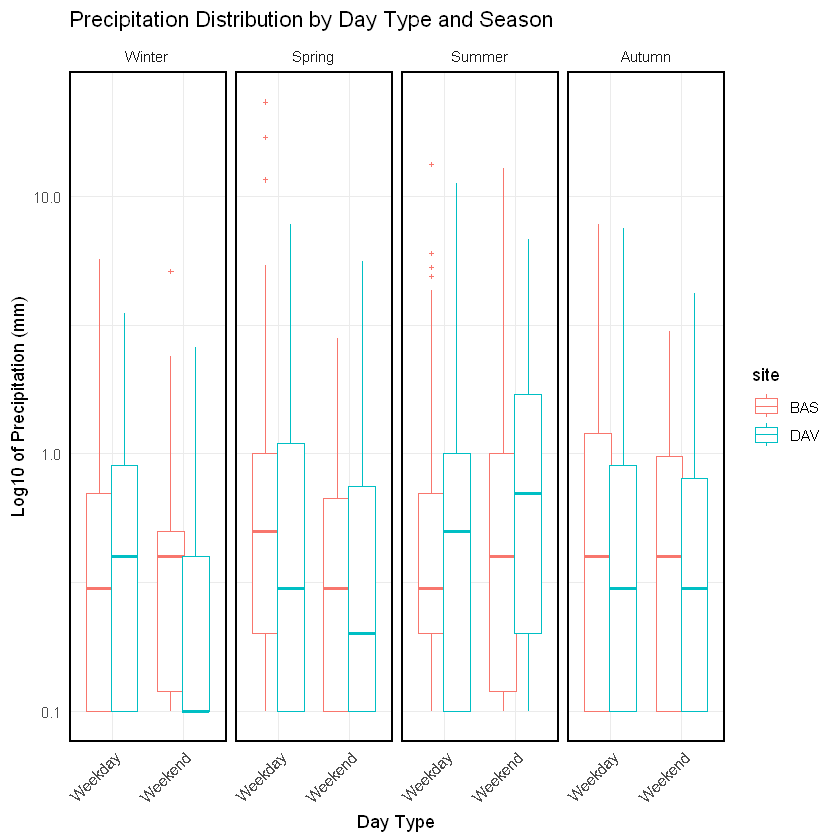

In [74]:
library(ggplot2)
library(dplyr)

# Filter the data for the PREC variable
daytype <- all_data_lf %>%
  filter(!is.na(value) & !is.na(season) & variable == "PREC")

# Create the plot for PREC only, with a log y scale and clear separation of seasons
daytype_plot <- ggplot(daytype) +
  facet_grid(~ season, scales = "free_y", labeller = labeller(
    variable = c(
      "PREC" = "PREC [mm]"
    )
  )) + 
  # Add the rectangle around each season facet
  geom_boxplot(
    aes(x = daytype, y = value, color = site),
    outlier.size = 0.5, 
    outlier.shape = 3,
    position = position_dodge(width = 0.7)  # Separate the boxplots for each season
  ) +
  scale_y_log10() +  # Apply log scale to y-axis
  labs(
    x = "Day Type",  # Label for the x-axis
    y = "Log10 of Precipitation (mm)",  # Label for the y-axis
    title = "Precipitation Distribution by Day Type and Season"  # Title for the plot
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    strip.text.y = element_text(size = 12, face = "bold"),  # Make facet labels bolder
    panel.border = element_rect(color = "black", fill = NA, size = 1)  # Add box around each facet
  )

# Print the plot
daytype_plot

# Save the plot
ggsave("outputs/daytype_prec_log_separated_seasons_with_boxes.jpeg", plot = daytype_plot, width = 6, height = 5, dpi = 300)


### Accumulated precipitations

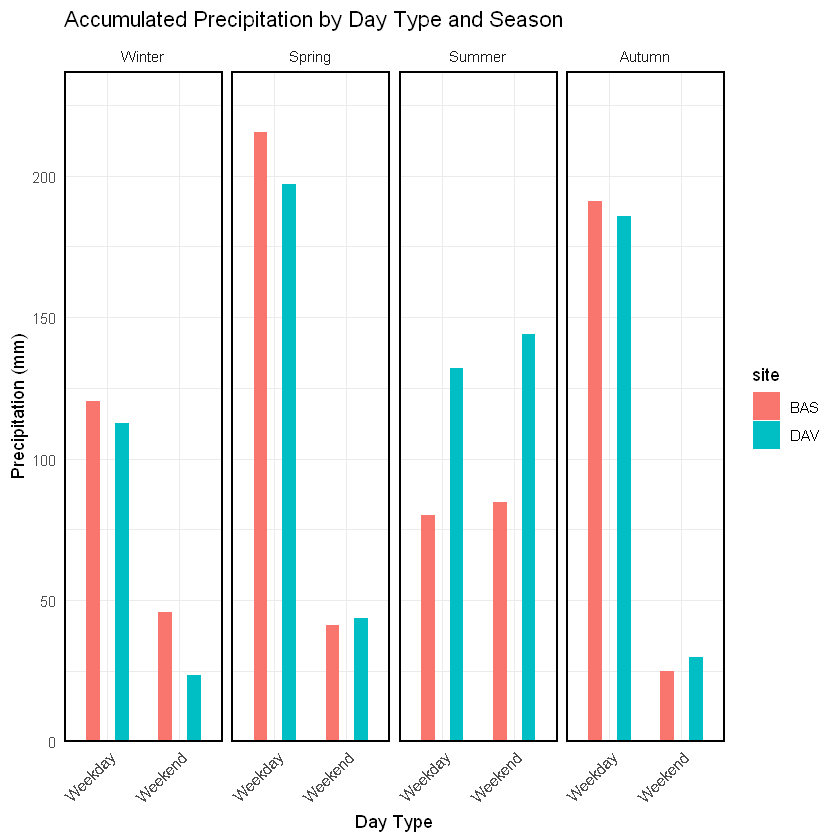

In [75]:
# Filter out NA values and calculate cumulative sum using reframe()
Precipitation_cumsum_data <- all_data_lf %>%
  filter(!is.na(value) & variable == "PREC" & !is.na(season)) %>%
  group_by(daytype, season, site) %>%
  reframe(
    cumsum_value = cumsum(value)  # Compute cumulative sum for each group
  )

# Create the plot
precipitations_plot_2 <- ggplot(Precipitation_cumsum_data, aes(
    x = daytype, 
    y = cumsum_value, 
    color = site,
    fill = site
  )) +
  facet_grid(~ season, scales = "free_y") +
  geom_bar(
    stat = "identity", 
    show.legend = TRUE, 
    position = position_dodge(width = 0.8),  # Separate bars for each site
    width = 0.35  # Adjust bar width to avoid overlap
  ) +
  scale_y_continuous("Precipitation (mm)", expand = expansion(mult = c(0, 0.1))) +  # Adjust label to reflect cumulative values
  theme_minimal() +
    labs(
    x = "Day Type",  # Label for the x-axis
    y = "Precipitation (mm)",  # Label for the y-axis
    title = "Accumulated Precipitation by Day Type and Season"  # Title for the plot
  ) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    strip.text.y = element_text(size = 12, face = "bold"),  # Make facet labels bolder
    panel.border = element_rect(color = "black", fill = NA, size = 1)  # Add box around each facet
  )

# Print the plot
precipitations_plot_2

ggsave("outputs/accumulated_precipitations_1.jpeg", plot = precipitations_plot_2, width = 6, height = 5, dpi = 300)


## Weekly variations

In [76]:
head(all_data_lf)

site,datetime,year,month,day,hour,dayofwk,daytype,season,variable,value
<chr>,<dttm>,<dbl>,<dbl>,<int>,<int>,<ord>,<chr>,<fct>,<chr>,<dbl>
DAV,2024-01-01,2024,1,1,0,Mon,Weekday,Winter,O3,57.7
DAV,2024-01-01,2024,1,1,0,Mon,Weekday,Winter,NO2,1.9
DAV,2024-01-01,2024,1,1,0,Mon,Weekday,Winter,PM10,1.2
DAV,2024-01-01,2024,1,1,0,Mon,Weekday,Winter,NOX,1.9
DAV,2024-01-01,2024,1,1,0,Mon,Weekday,Winter,TEMP,-2.2
DAV,2024-01-01,2024,1,1,0,Mon,Weekday,Winter,PREC,0.0


In [77]:
Percentile <- function(perc) function(x) 
  ## `perc` is the percentile which should be computed for the numeric vector `x`
  quantile(x, perc*1e-2, na.rm=TRUE)

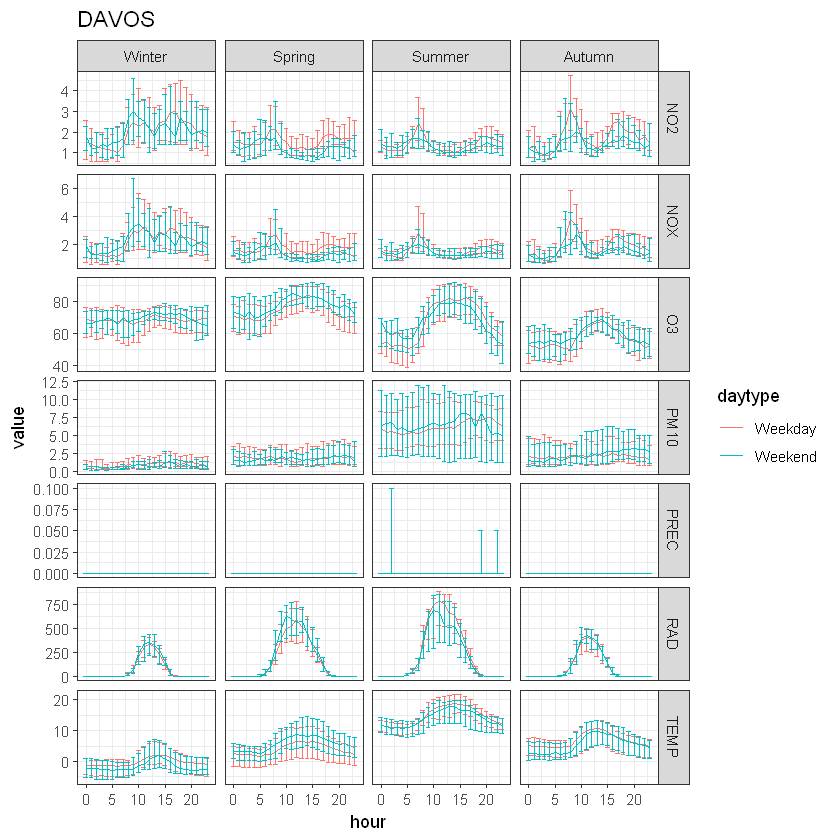

In [78]:
Diurnal_profile_DAV <- all_data_lf %>%
  filter(site=="DAV" & !is.na(value) & !is.na(season)) %>%
  ggplot(aes(x=hour, y=value, group=daytype, color=daytype)) +
  facet_grid(variable ~ season, scale = "free_y", drop=TRUE) +
  geom_line(stat="summary", fun="median")+
  geom_errorbar(stat="summary",
                fun.min=Percentile(25),
                fun.max=Percentile(75))+
  ggtitle("DAVOS")

Diurnal_profile_DAV
ggsave("outputs/Diurnal_profile_DAV.jpeg", plot = Diurnal_profile_DAV, width = 8, height = 6, dpi = 400)

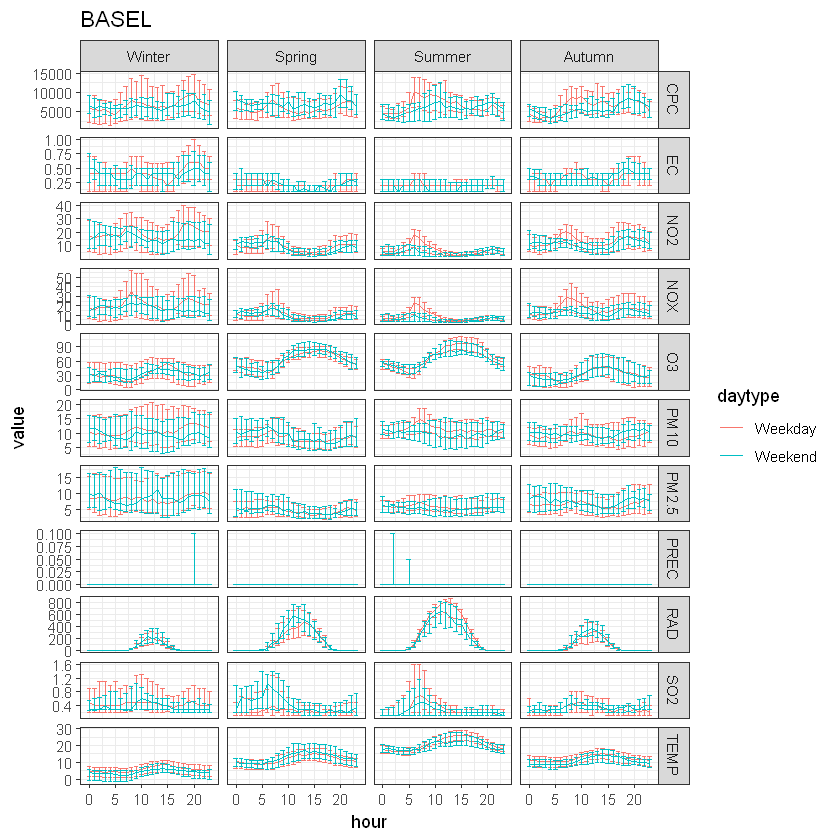

In [79]:
Diurnal_profile_BAS <- all_data_lf %>%
  filter(site=="BAS" & !is.na(value) & !is.na(season)) %>%
  ggplot(aes(x=hour, y=value, group=daytype, color=daytype)) +
  facet_grid(variable ~ season, scale = "free_y", drop=TRUE) +
  geom_line(stat="summary", fun="median")+
  geom_errorbar(stat="summary",
                fun.min=Percentile(25),
                fun.max=Percentile(75))+
  ggtitle("BASEL")

Diurnal_profile_BAS
ggsave("outputs/Diurnal_profile_BAS.jpeg", plot = Diurnal_profile_BAS, width = 8, height = 6, dpi = 400)

In [80]:
all_data_lf$variable <- factor(
  all_data_lf$variable,
  levels = c("NO2", "NOX", "O3", "PM10", setdiff(unique(all_data_lf$variable), c("NO2", "NOX", "O3", "PM10")))
)

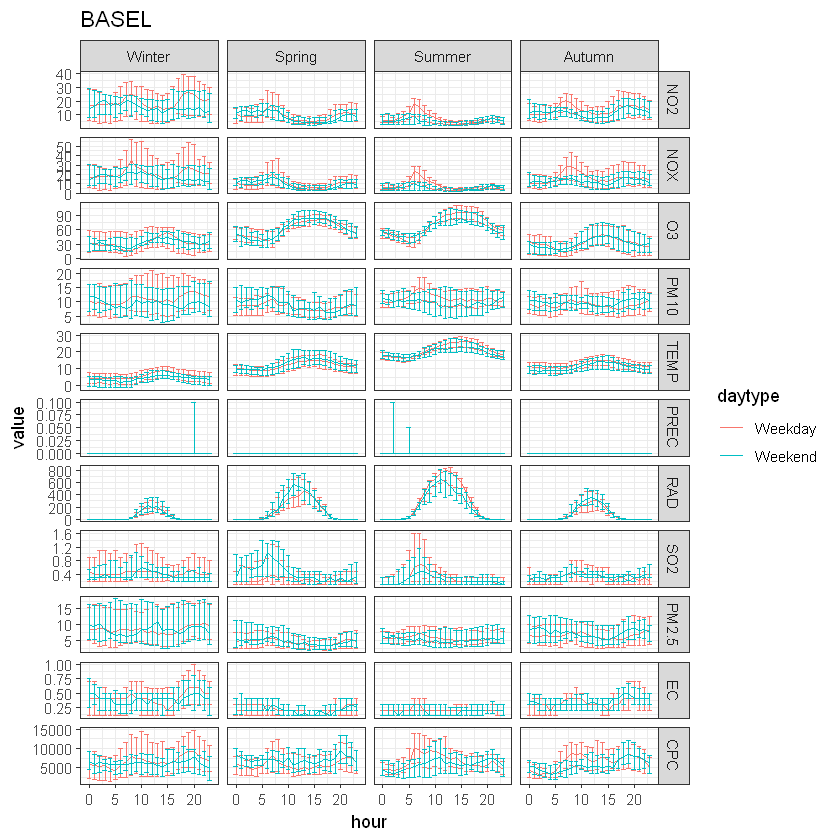

In [81]:
Diurnal_profile_BAS <- all_data_lf %>%
  filter(site == "BAS" & !is.na(value) & !is.na(season)) %>%
  ggplot(aes(x = hour, y = value, group = daytype, color = daytype)) +
  facet_grid(variable ~ season, scale = "free_y", drop = TRUE) +
  geom_line(stat = "summary", fun = "median") +
  geom_errorbar(
    stat = "summary",
    fun.min = function(x) quantile(x, 0.25, na.rm = TRUE),
    fun.max = function(x) quantile(x, 0.75, na.rm = TRUE)
  ) +
  ggtitle("BASEL")

Diurnal_profile_BAS
ggsave("outputs/Diurnal_profile_BAS.jpeg", plot = Diurnal_profile_BAS, width = 8, height = 6, dpi = 400)

Warning message:
"Removed 85 rows containing non-finite values (`stat_summary()`)."
Warning message:
"Removed 85 rows containing non-finite values (`stat_summary()`)."
Warning message:
"Removed 85 rows containing non-finite values (`stat_summary()`)."
Warning message:
"Removed 85 rows containing non-finite values (`stat_summary()`)."


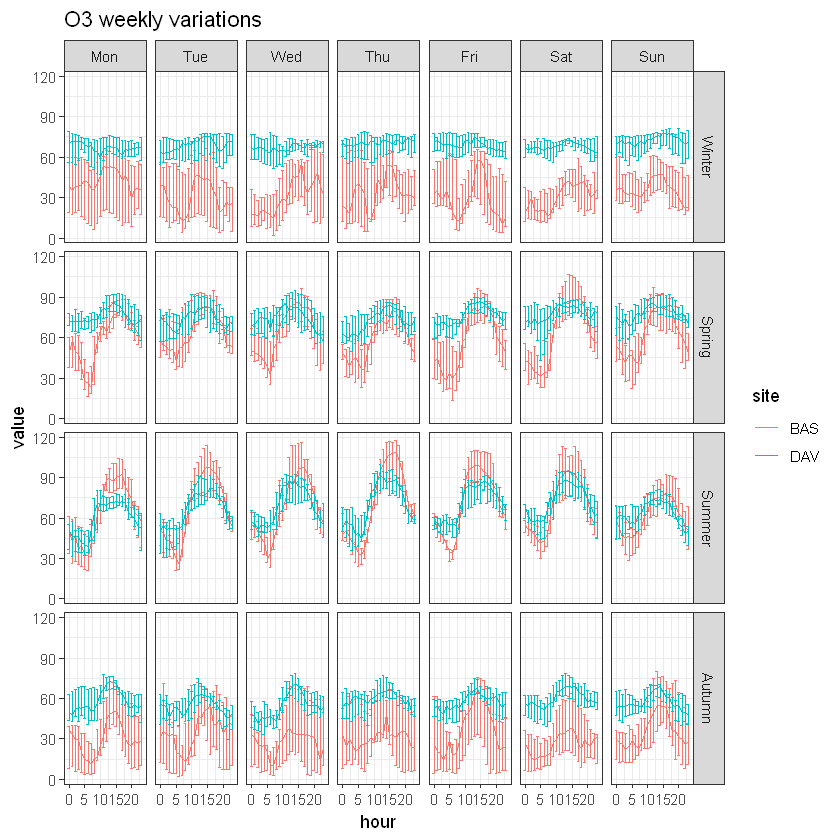

In [82]:
Ozone_weekly_variation <-all_data_lf %>%
  filter(variable=="O3"& !is.na(season)) %>%
  ggplot(aes(x=hour, y=value, group=site, color=site)) +
  facet_grid(season ~ dayofwk, drop=TRUE) +
  geom_line(stat="summary", fun="median")+
  geom_errorbar(stat="summary",
                fun.min=Percentile(25),
                fun.max=Percentile(75))+
  ggtitle("O3 weekly variations")

Ozone_weekly_variation
ggsave("outputs/Ozone_weekly_variation_hourly.jpeg", plot = Ozone_weekly_variation, width = 8, height = 6, dpi = 400)

In [83]:
mean_sd <- function(x) {
  m <- mean(x, na.rm = TRUE)
  s <- sd(x, na.rm = TRUE)
  data.frame(y = m, ymin = m - s, ymax = m + s)
}

Warning message:
"Removed 85 rows containing non-finite values (`stat_summary()`)."
Warning message:
"Removed 85 rows containing non-finite values (`stat_summary()`)."
Warning message:
"Removed 85 rows containing non-finite values (`stat_summary()`)."
Warning message:
"Removed 85 rows containing non-finite values (`stat_summary()`)."


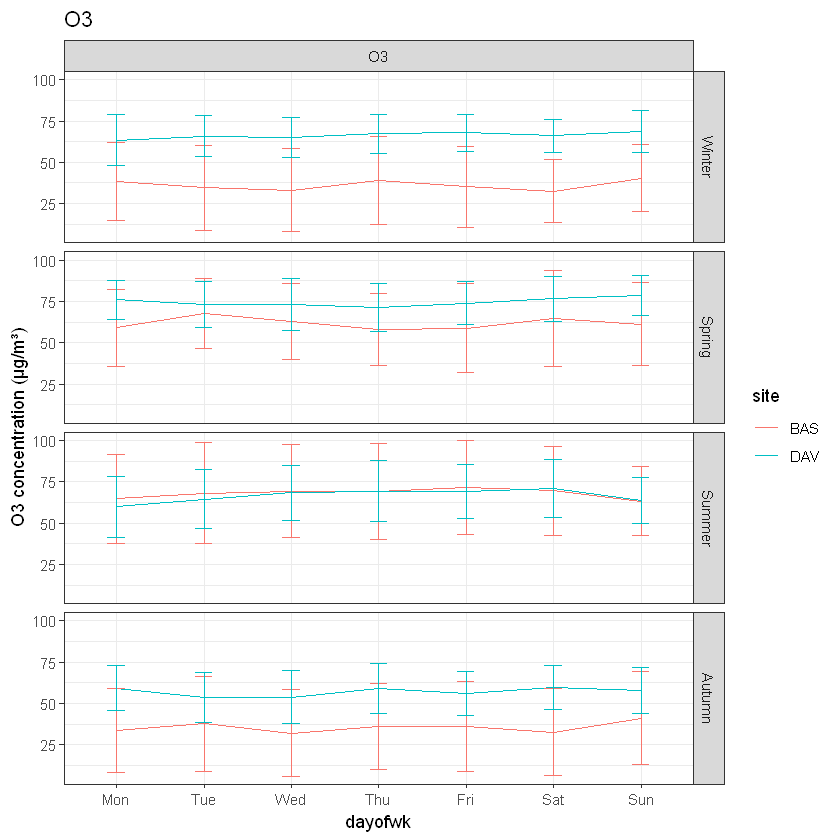

In [84]:
ozone_daily_mean_weekly_variation <-all_data_lf %>%
  filter(variable == "O3" & !is.na(season)) %>%
  ggplot(aes(x = dayofwk, y = value, group = site, color = site)) +
  facet_grid(season ~ variable, drop = TRUE) +
  stat_summary(fun = mean, geom = "line") +
  stat_summary(fun.data = mean_sd, geom = "errorbar", width = 0.2) +
  ggtitle("O3") +
  ylab("O₃ concentration (µg/m³)")

ozone_daily_mean_weekly_variation
ggsave("outputs/ozone_daily_mean_weekly_variation.jpeg", plot = ozone_daily_mean_weekly_variation, width = 8, height = 6, dpi = 400)

In [85]:
library(dplyr)
library(ggplot2)

# Step 1: Extract daily max per pollutant, site, and day
daily_max <- all_data_lf %>%
  group_by(site, season, variable, year, month, day) %>%
  summarise(
    day_max = max(value, na.rm = TRUE),
    dayofwk = first(dayofwk),  # Get corresponding weekday
    .groups = "drop"
  )

# Step 2: Compute mean and sd of daily max by day of the week
weekly_stats <- daily_max %>%
  group_by(season, site,variable, dayofwk) %>%
  summarise(
    mean_val = mean(day_max, na.rm = TRUE),
    sd_val = sd(day_max, na.rm = TRUE),
    .groups = "drop"
  )

Warning message:
"There were 1487 warnings in `summarise()`.
The first warning was:
i In argument: `day_max = max(value, na.rm = TRUE)`.
i In group 771: `site = "BAS"`, `season = Winter`, `variable = PM2.5`, `year = 2024`, `month = 2`, `day = 12`.
Caused by warning in `max()`:
! aucun argument pour max ; -Inf est renvoyé
i Run `dplyr::last_dplyr_warnings()` to see the 1486 remaining warnings."


In [86]:
head(weekly_stats)

season,site,variable,dayofwk,mean_val,sd_val
<fct>,<chr>,<fct>,<ord>,<dbl>,<dbl>
Winter,BAS,NO2,Mon,33.20714,15.48272
Winter,BAS,NO2,Tue,36.98571,13.31771
Winter,BAS,NO2,Wed,39.10769,15.84716
Winter,BAS,NO2,Thu,36.88462,13.61952
Winter,BAS,NO2,Fri,40.68333,14.08770
Winter,BAS,NO2,Sat,33.88333,11.78966


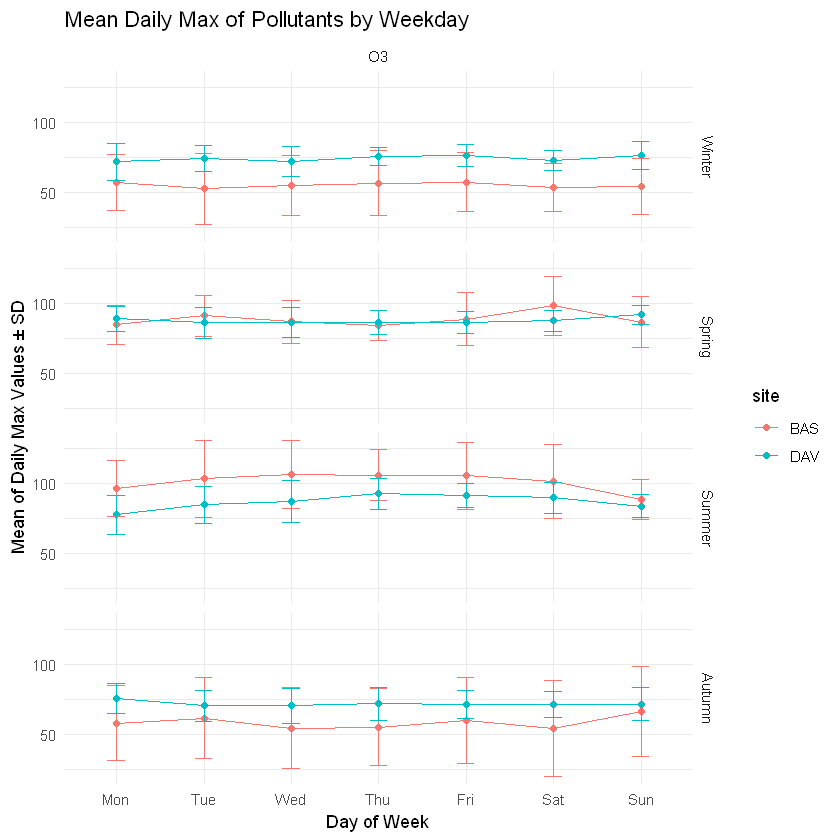

In [87]:
# Step 3: Plot mean ± sd for each pollutant across weekdays
ozone_daily_max_weekly_variation<-weekly_stats %>%
filter(variable == "O3") %>%
ggplot(aes(x = dayofwk, y = mean_val, group = site, color = site)) +
facet_grid(season ~ variable, drop = TRUE) +
  geom_line() +
  geom_point() +
  geom_errorbar(aes(ymin = mean_val - sd_val, ymax = mean_val + sd_val), width = 0.2) +
  ylab("Mean of Daily Max Values ± SD") +
  xlab("Day of Week") +
  ggtitle("Mean Daily Max of Pollutants by Weekday") +
  theme_minimal()

ozone_daily_max_weekly_variation
ggsave("outputs/ozone_daily_max_weekly_variation.jpeg", plot = ozone_daily_max_weekly_variation, width = 8, height = 6, dpi = 400)

## T-test to see whether weekend concentrations are statistically different from weekdays's

In [88]:
head(all_data_df)

site,datetime,year,month,day,hour,dayofwk,daytype,season,O3,NO2,PM10,NOX,TEMP,PREC,RAD,SO2,PM2.5,EC,CPC
<chr>,<dttm>,<dbl>,<dbl>,<int>,<int>,<ord>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DAV,2024-01-01 00:00:00,2024,1,1,0,Mon,Weekday,Winter,57.7,1.9,1.2,1.9,-2.2,0,-0.6,NA,NA,NA,NA
DAV,2024-01-01 01:00:00,2024,1,1,1,Mon,Weekday,Winter,55.2,2.1,1.5,2.1,-2.8,0,-0.7,NA,NA,NA,NA
DAV,2024-01-01 02:00:00,2024,1,1,2,Mon,Weekday,Winter,49.9,3.7,2.2,3.7,-3.3,0,-0.7,NA,NA,NA,NA
DAV,2024-01-01 03:00:00,2024,1,1,3,Mon,Weekday,Winter,52.1,4.5,3.0,4.6,-4.2,0,-1.1,NA,NA,NA,NA
DAV,2024-01-01 04:00:00,2024,1,1,4,Mon,Weekday,Winter,65.8,0.7,0.2,0.7,-5.2,0,-1.3,NA,NA,NA,NA
DAV,2024-01-01 05:00:00,2024,1,1,5,Mon,Weekday,Winter,67.1,0.7,0.4,0.7,-5.6,0,-0.8,NA,NA,NA,NA


### Overall mean differences differences

#### TEST DAVOS

In [89]:
# Environmental variables to test in DAVOS
environmental_variables <- c("O3", "NO2", "PM10", "NOX", "TEMP", "PREC", "RAD")

# Loop through the variables
for (var in environmental_variables) {
  
  # Filter data for weekends and weekdays
  O3_weekends_DAV <- all_data_lf %>%
    filter(site == "DAV", variable == var & daytype == "Weekend")
  
  O3_weekdays_DAV <- all_data_lf %>%
    filter(site == "DAV", variable == var & daytype == "Weekday")
  
  # Perform t-test
  test_result <- t.test(O3_weekends_DAV$value, O3_weekdays_DAV$value)
  
  # Print the results
  cat("T-test results for", var, ":\n")
  print(test_result)
  cat("\n")  # Adds a blank line for better readability
}


T-test results for O3 :

	Welch Two Sample t-test

data:  O3_weekends_DAV$value and O3_weekdays_DAV$value
t = 6.1738, df = 4824.1, p-value = 7.214e-10
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 1.553113 2.998439
sample estimates:
mean of x mean of y 
 67.80048  65.52470 


T-test results for NO2 :

	Welch Two Sample t-test

data:  O3_weekends_DAV$value and O3_weekdays_DAV$value
t = -9.9966, df = 5941.2, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.3867356 -0.2599240
sample estimates:
mean of x mean of y 
 1.717909  2.041238 


T-test results for PM10 :

	Welch Two Sample t-test

data:  O3_weekends_DAV$value and O3_weekdays_DAV$value
t = 1.4787, df = 5158.5, p-value = 0.1393
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.1631074  1.1644710
sample estimates:
mean of x mean of y 
 5.493590  4.992908 




In [58]:
# Environmental variables to test in DAVOS, season details
environmental_variables <- c("O3", "NO2", "PM10", "NOX", "TEMP", "PREC", "RAD")

# Loop through the variables
for (var in environmental_variables) {
  
   for (season in c("Winter", "Spring", "Summer", "Autumn")){
  
      # Filter data for weekends and weekdays
      O3_weekends_DAV <- all_data_lf %>%
        filter(season == season, site == "DAV", variable == var & daytype == "Weekend")
      
      O3_weekdays_DAV <- all_data_lf %>%
        filter(season==season, site == "DAV", variable == var & daytype == "Weekday")
      
      # Perform t-test
      test_result <- t.test(O3_weekends_DAV$value, O3_weekdays_DAV$value)
      
      # Print the results
      cat("T-test results for", var, "during", season, ":\n")
      print(test_result)
      cat("\n")  # Adds a blank line for better readability
    }
}


T-test results for O3 during Winter :

	Welch Two Sample t-test

data:  O3_weekends_DAV$value and O3_weekdays_DAV$value
t = 6.1738, df = 4824.1, p-value = 7.214e-10
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 1.553113 2.998439
sample estimates:
mean of x mean of y 
 67.80048  65.52470 


T-test results for O3 during Spring :

	Welch Two Sample t-test

data:  O3_weekends_DAV$value and O3_weekdays_DAV$value
t = 6.1738, df = 4824.1, p-value = 7.214e-10
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 1.553113 2.998439
sample estimates:
mean of x mean of y 
 67.80048  65.52470 


T-test results for O3 during Summer :

	Welch Two Sample t-test

data:  O3_weekends_DAV$value and O3_weekdays_DAV$value
t = 6.1738, df = 4824.1, p-value = 7.214e-10
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 1.553113 2.998439
sample estimates:
mean of x

#### RESULTS DAVOS

In [92]:
# Environmental variables to test in DAVOS, season details
environmental_variables <- c("O3", "NO2", "PM10", "NOX", "TEMP", "PREC", "RAD")

# Initialize empty list to store results
results_list <- list()

# Loop through the variables
for (var in environmental_variables) {
  for (s in c("Winter", "Spring", "Summer", "Autumn")) {
    
    # Filter data for weekends and weekdays
      if (s=="Winter" | s=="Summer"){
          weekend_data <- all_data_lf %>%
      filter(season == s, site == "DAV", variable == var, daytype == "Weekend")
    
    weekday_data <- all_data_lf %>%
      filter(season == s, site == "DAV", variable == var, daytype == "Weekday")
    
    # Perform t-test if both groups have sufficient data
    if (length(weekend_data$value) > 1 && length(weekday_data$value) > 1) {
      test_result <- t.test(weekend_data$value, weekday_data$value)
      
      # Compute mean difference
      mean_wd <- mean(weekday_data$value, na.rm = TRUE)
      mean_we <- mean(weekend_data$value, na.rm = TRUE)
      
      # Append results to the list
      results_list[[length(results_list) + 1]] <- data.frame(
        Variable = var,
        Season = s,
        Mean_Weekdays = mean_wd,
        Mean_Weekends = mean_we,
        P_Value = test_result$p.value
      )
     }
    }
  }
}

# Combine all results into a single data frame
results_table <- do.call(rbind, results_list)

# View the result
results_table


Variable,Season,Mean_Weekdays,Mean_Weekends,P_Value
<chr>,<chr>,<dbl>,<dbl>,<dbl>
O3,Winter,65.76953768,67.40850000,4.117057e-03
O3,Summer,66.29448010,67.35216049,1.806886e-01
NO2,Winter,2.54331856,2.36700000,4.818163e-02
NO2,Summer,1.58942618,1.42731481,1.596637e-05
PM10,Winter,1.83598485,1.19500000,4.419067e-11
PM10,Summer,8.29679487,8.86141975,2.593082e-01
NOX,Winter,2.87384421,2.64450000,2.810858e-02
NOX,Summer,1.78459059,1.59583333,1.572551e-05
TEMP,Winter,-0.72007576,-1.40816667,1.253878e-03


#### TEST BASEL 

In [53]:
# Environmental variables to test in BASEL
environmental_variables <- c("O3", "NO2", "PM10", "NOX", "TEMP", "PREC", "RAD", "SO2", "PM2.5", "EC", "CPC")

# Loop through the variables
for (var in environmental_variables) {
   
  
      # Filter data for weekends and weekdays
      O3_weekends_BAS <- all_data_lf %>%
        filter(site == "BAS", variable == var & daytype == "Weekend")
      
      O3_weekdays_BAS <- all_data_lf %>%
        filter(site == "BAS", variable == var & daytype == "Weekday")
      
      # Perform t-test
      test_result <- t.test(O3_weekends_BAS$value, O3_weekdays_BAS$value)
      
      # Print the results
      cat("T-test results for", var, ":\n")
      print(test_result)
      cat("\n")  # Adds a blank line for better readability

}

T-test results for O3 :

	Welch Two Sample t-test

data:  O3_weekends_BAS$value and O3_weekdays_BAS$value
t = 1.3565, df = 4700.8, p-value = 0.175
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.418884  2.300452
sample estimates:
mean of x mean of y 
 51.20061  50.25982 


T-test results for NO2 :

	Welch Two Sample t-test

data:  O3_weekends_BAS$value and O3_weekdays_BAS$value
t = -9.2736, df = 5543.1, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.527312 -1.645253
sample estimates:
mean of x mean of y 
 11.04953  13.13582 


T-test results for PM10 :

	Welch Two Sample t-test

data:  O3_weekends_BAS$value and O3_weekdays_BAS$value
t = -1.3714, df = 4419.7, p-value = 0.1703
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.6320214  0.1117384
sample estimates:
mean of x mean of y 
 11.00636  11.26651 


T-t

In [54]:
# Environmental variables to test in BASEL tested every months
environmental_variables <- c("O3", "NO2", "PM10", "NOX", "TEMP", "PREC", "RAD", "SO2", "PM2.5", "EC", "CPC")

# Loop through the variables
for (var in environmental_variables) {
    for (i in seq(1,12, by=1)){
  
      # Filter data for weekends and weekdays
      O3_weekends_BAS <- all_data_lf %>%
        filter(month==i, site == "BAS", variable == var & daytype == "Weekend")
      
      O3_weekdays_BAS <- all_data_lf %>%
        filter(month==i, site == "BAS", variable == var & daytype == "Weekday")
      
      # Perform t-test
      test_result <- t.test(O3_weekends_BAS$value, O3_weekdays_BAS$value)
      
      # Print the results
      cat("T-test results for", var, "during month ", i, ":\n")
      print(test_result)
      cat("\n")  # Adds a blank line for better readability
    }
}

T-test results for O3 during month  1 :

	Welch Two Sample t-test

data:  O3_weekends_BAS$value and O3_weekdays_BAS$value
t = -6.8298, df = 697.9, p-value = 1.852e-11
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -12.658267  -7.005508
sample estimates:
mean of x mean of y 
 27.08542  36.91730 


T-test results for O3 during month  2 :

	Welch Two Sample t-test

data:  O3_weekends_BAS$value and O3_weekdays_BAS$value
t = 0.29662, df = 415.11, p-value = 0.7669
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.939042  3.983672
sample estimates:
mean of x mean of y 
 44.78646  44.26414 


T-test results for O3 during month  3 :

	Welch Two Sample t-test

data:  O3_weekends_BAS$value and O3_weekdays_BAS$value
t = -0.72008, df = 459.48, p-value = 0.4718
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -5.057163  2.344862
sample estimates

#### RESULTS BASEL

In [93]:
# Environmental variables to test in DAVOS, season details
environmental_variables <- c("O3", "NO2", "PM10", "NOX", "TEMP", "PREC", "RAD", "SO2", "PM2.5", "EC", "CPC")

# Initialize empty list to store results
results_list <- list()

# Loop through the variables
for (var in environmental_variables) {
  for (s in c("Winter", "Spring", "Summer", "Autumn")) {
    
    # Filter data for weekends and weekdays
      if (s=="Winter" | s=="Summer"){
          weekend_data <- all_data_lf %>%
      filter(season == s, site == "BAS", variable == var, daytype == "Weekend")
    
    weekday_data <- all_data_lf %>%
      filter(season == s, site == "BAS", variable == var, daytype == "Weekday")
    
    # Perform t-test if both groups have sufficient data
    if (length(weekend_data$value) > 1 && length(weekday_data$value) > 1) {
      test_result <- t.test(weekend_data$value, weekday_data$value)
      
      # Compute mean difference
      mean_wd <- mean(weekday_data$value, na.rm = TRUE)
      mean_we <- mean(weekend_data$value, na.rm = TRUE)
      
      # Append results to the list
      results_list[[length(results_list) + 1]] <- data.frame(
        Variable = var,
        Season = s,
        Mean_Weekdays = mean_wd,
        Mean_Weekends = mean_we,
        P_Value = test_result$p.value
      )
     }
    }
  }
}

# Combine all results into a single data frame
results_table <- do.call(rbind, results_list)

# View the result
results_table


Variable,Season,Mean_Weekdays,Mean_Weekends,P_Value
<chr>,<chr>,<dbl>,<dbl>,<dbl>
O3,Winter,3.606188e+01,36.5297203,6.576583e-01
O3,Summer,6.863570e+01,66.5888889,8.965698e-02
NO2,Winter,1.987736e+01,17.1223776,6.341496e-06
NO2,Summer,7.565464e+00,5.7723765,2.341027e-18
PM10,Winter,1.303640e+01,12.2459790,1.123814e-01
PM10,Summer,1.200911e+01,10.7422840,2.218067e-06
NOX,Winter,2.587807e+01,19.7477273,3.091697e-13
NOX,Summer,8.818106e+00,6.4132716,6.044092e-22
TEMP,Winter,5.098611e+00,3.6005000,3.706483e-12
